In [168]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import matplotlib as mpl

mpl.rcParams['figure.figsize'] = (10, 6)
mpl.rcParams['axes.grid'] = False

In [239]:
data = pd.read_csv('train_mnist.csv')
n = data.shape[0]
train_df = data.iloc[:int(n*0.8), :]
test_df = data.iloc[int(n*0.8):, :]



# Análisis Exploratorio de Datos

<BarContainer object of 10 artists>

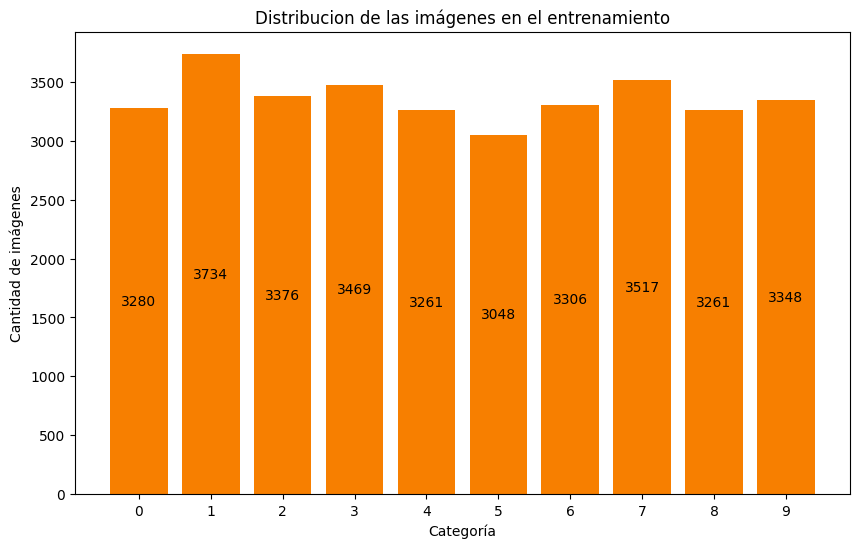

In [186]:
s = pd.Series(train_df['label'], dtype="category")
categories = np.array(s.cat.categories)
counts = np.array(s.value_counts(sort=False))
bar_labels = [str(i) for i in categories]
plt.bar_label(plt.bar(bar_labels, counts, color='#f77f00'), label_type='center')
plt.title('Distribucion de las imágenes en el entrenamiento')
plt.xlabel('Categoría')
plt.ylabel('Cantidad de imágenes')
plt.bar(bar_labels, counts, label=bar_labels, color='#f77f00')


Se puede observar que las categorías no están balanceadas. La categoría 1 tiene más observaciones que las demás (`3734`). A continuación observamos un ejemplo de cada imágen:

In [240]:
samples = []
for i in range(10):
		sample = (train_df.loc[train_df['label'] == i])[:1]
		# Drop the label column
		sample = sample.drop(labels = ['label'],axis = 1)
		# Convert the dataframe to a numpy array
		# sample =[(v,v,v) for v in np.array(sample)]
		sample = np.array(sample)
		# Reshape the array into 28 x 28 array (2-dimensional array)
		sample = sample.reshape(28, 28)
		sample = sample.astype('uint8')
		samples.append(sample)

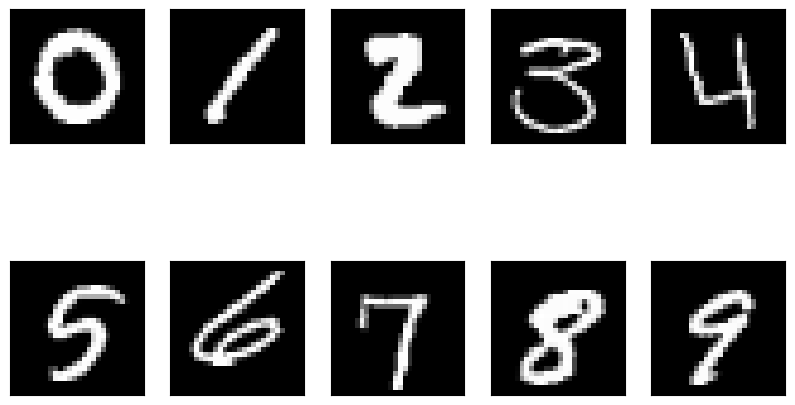

In [241]:

fig, ax = plt.subplots(2,5)
for axi in ax.flat:
		axi.xaxis.set_visible(False)
		axi.yaxis.set_visible(False)

for i in range(2):
	for j in range(5):
		image = samples[i*5+j]
		ax[i,j].imshow(image, cmap='gray')

# Utilizando Modelos 

In [268]:
train_df = data.iloc[:int(n*0.8), :]
test_df = data.iloc[int(n*0.8):, :]
y = train_df['label']
train_df = train_df.drop(['label'], axis=1)
X_train = train_df

y_test = test_df['label']
test_df = test_df.drop(['label'], axis=1)
X_test = test_df

## Red Neuronal Simple

In [269]:
from sklearn.neural_network import MLPClassifier
from sklearn import preprocessing



In [387]:
scaler = preprocessing.StandardScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)

In [388]:
clf = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(5,3,9), random_state=1, max_iter=1000)
clf.fit(np.array(X_train_scaled), np.array(y))


/Users/guillermosantosbarrios/Developer/Universidad/2023/Data Science/uvg_data_science_lab_3/venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


MLPClassifier(alpha=1e-05, hidden_layer_sizes=(5, 3, 9), max_iter=1000,
              random_state=1, solver='lbfgs')

In [411]:
X_test_scaled = scaler.transform(X_test)
predictions = clf.predict(X_test_scaled)

A continuación se verifica la calidad del modelo prediciendo

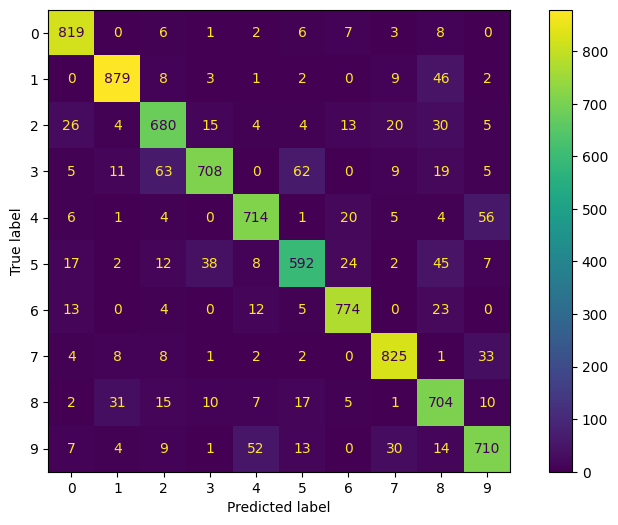

In [291]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score
cm = confusion_matrix(y_test, predictions, labels=clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
disp.plot()


In [412]:
nn_accuracy = accuracy_score(y_test, predictions, normalize=True)
print(nn_accuracy)

0.881547619047619


El accuracy para el modelo es de `0.8815`

## Deep Learning Con Redes Neuronales Convolucionales

In [295]:
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt

In [350]:
model = models.Sequential()
model.add(layers.Conv2D(28, (3,3), activation='relu', input_shape=(28, 28, 1)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(10, activation='softmax'))
model.summary()


Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_18 (Conv2D)          (None, 26, 26, 28)        280       
                                                                 
 max_pooling2d_12 (MaxPooli  (None, 13, 13, 28)        0         
 ng2D)                                                           
                                                                 
 conv2d_19 (Conv2D)          (None, 11, 11, 64)        16192     
                                                                 
 max_pooling2d_13 (MaxPooli  (None, 5, 5, 64)          0         
 ng2D)                                                           
                                                                 
 conv2d_20 (Conv2D)          (None, 3, 3, 64)          36928     
                                                                 
 flatten_3 (Flatten)         (None, 576)              

In [351]:
X_train_reshaped = X_train_scaled.reshape(-1, 28, 28, 1)


early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=3,)
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

history = model.fit(np.array(X_train_reshaped), np.array(y), epochs=10, 
                    validation_split=0.2, callbacks=[early_stopping_cb])
									


Epoch 1/10
  1/840 [..............................] - ETA: 2:36 - loss: 2.3086 - accuracy: 0.1562

/Users/guillermosantosbarrios/Developer/Universidad/2023/Data Science/uvg_data_science_lab_3/venv/lib/python3.11/site-packages/keras/src/backend.py:5714: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


840/840 [==============================] - 5s 6ms/step - loss: 0.2137 - accuracy: 0.9331 - val_loss: 0.0774 - val_accuracy: 0.9749
Epoch 2/10
840/840 [==============================] - 5s 6ms/step - loss: 0.0604 - accuracy: 0.9814 - val_loss: 0.0744 - val_accuracy: 0.9784
Epoch 3/10
840/840 [==============================] - 5s 6ms/step - loss: 0.0427 - accuracy: 0.9863 - val_loss: 0.0487 - val_accuracy: 0.9841
Epoch 4/10
840/840 [==============================] - 5s 6ms/step - loss: 0.0308 - accuracy: 0.9900 - val_loss: 0.0444 - val_accuracy: 0.9876
Epoch 5/10
840/840 [==============================] - 5s 6ms/step - loss: 0.0248 - accuracy: 0.9925 - val_loss: 0.0568 - val_accuracy: 0.9833
Epoch 6/10
840/840 [==============================] - 5s 6ms/step - loss: 0.0209 - accuracy: 0.9930 - val_loss: 0.0443 - val_accuracy: 0.9878
Epoch 7/10
840/840 [==============================] - 5s 6ms/step - loss: 0.0189 - accuracy: 0.9942 - val_loss: 0.0458 - val_accuracy: 0.9876
Epoch 8/10
840/84

In [352]:
X_test_reshaped = X_test_scaled.reshape(-1, 28, 28, 1)


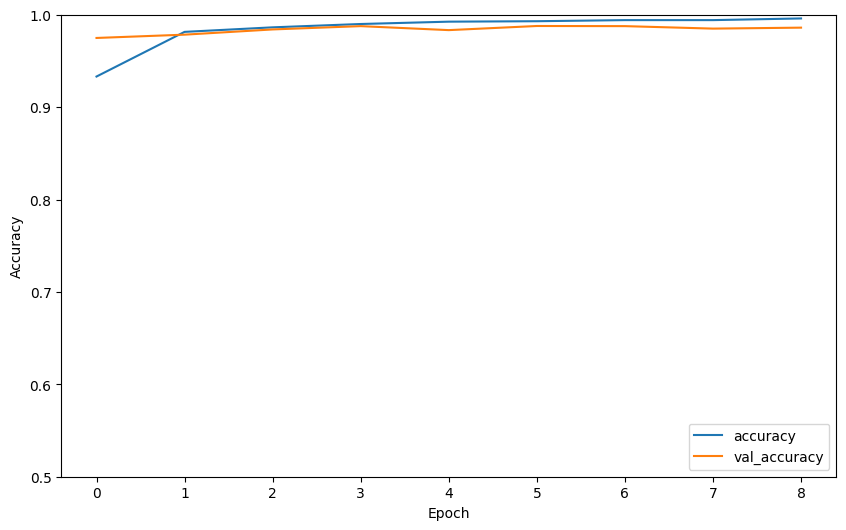

In [353]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')


In [421]:
test_loss, test_acc = model.evaluate(np.array(X_test_reshaped),  np.array(y_test), verbose=2)
rnn_accu = test_acc


263/263 - 0s - loss: 0.0568 - accuracy: 0.9879 - 408ms/epoch - 2ms/step


La accuracy para el modelo es de `0.9870`

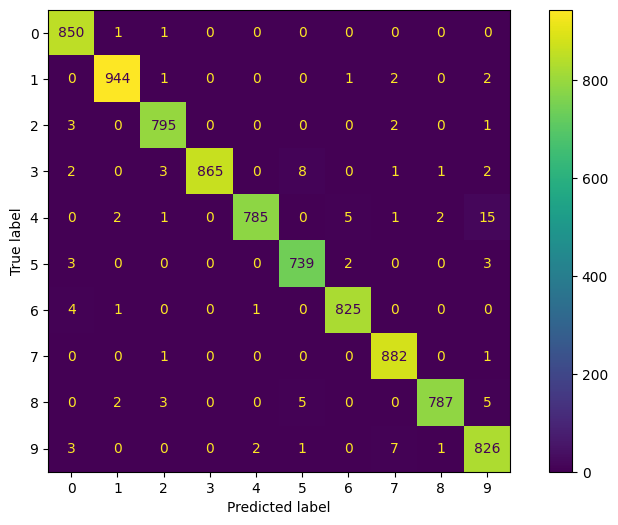

In [383]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score

confussion_matrix = confusion_matrix(np.array(y_test), np.array(indices),)
disp = ConfusionMatrixDisplay(confusion_matrix=confussion_matrix, display_labels=bar_labels)
disp.plot()



## Utilizando KNN

In [389]:
from sklearn.neighbors import KNeighborsClassifier
neigh = KNeighborsClassifier(n_neighbors=3)

scaler = preprocessing.StandardScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)
neigh.fit(np.array(X_train_scaled), y)

KNeighborsClassifier(n_neighbors=3)

In [400]:
knn_predictions = neigh.predict(np.array(X_test_scaled))

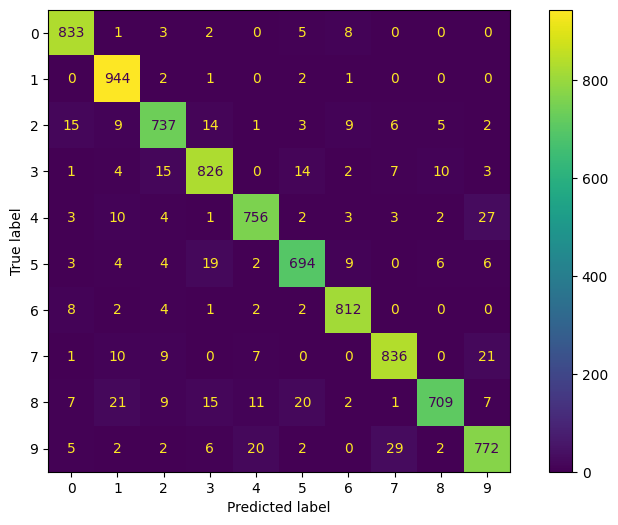

In [420]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score

confussion_matrix = confusion_matrix(np.array(y_test), np.array(knn_predictions),)
disp = ConfusionMatrixDisplay(confusion_matrix=confussion_matrix, display_labels=bar_labels)
disp.plot()

In [419]:
knn_accuracy = accuracy_score(y_test, knn_predictions, normalize=True)
print(knn_accuracy)

0.9427380952380953


## Comparando Modelos

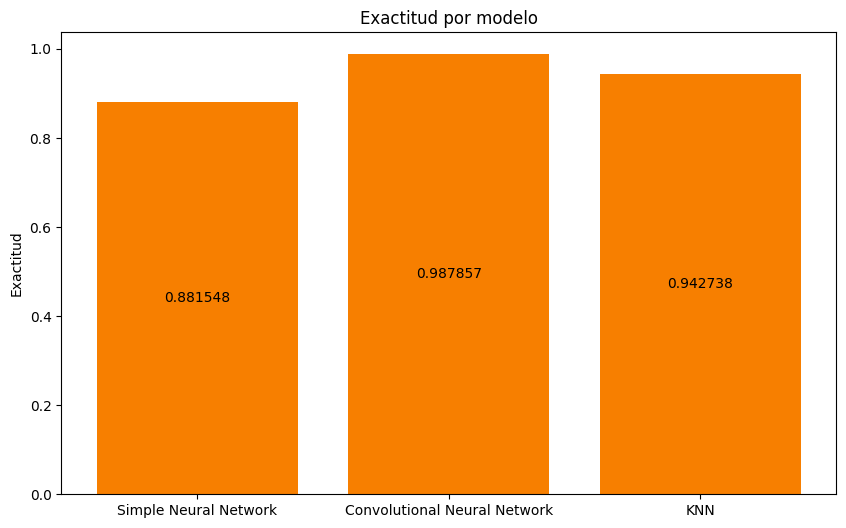

In [424]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()

models = ['Simple Neural Network', 'Convolutional Neural Network', 'KNN']
accuracies = [nn_accuracy, rnn_accu, knn_accuracy]
ax.bar(models, accuracies,color='#f77f00')
plt.bar_label(plt.bar(models, accuracies, color='#f77f00'), label_type='center')

ax.set_ylabel('Exactitud')
ax.set_title('Exactitud por modelo')
plt.show()